#  Import Dependencies

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import os
import time
from matplotlib import pyplot as plt
import tensorflow as tf
import sklearn

# Extract Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [8]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #Read Feed
        ret, frame = cap.read()

        #Make detection
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        #Draw Landamrks
        draw_styled_landmarks(frame, results)

        cv2.imshow("Cam Feed", frame)

        if cv2.waitKey(10) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()

# 3. Extract Keypoint Values

In [9]:
for res in results.face_landmarks.landmark:
    test = np.array([res.x, res.y, res.z])
test

array([0.68432552, 0.35918081, 0.02223108])

In [10]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [15]:
len(results.pose_landmarks.landmark)

33

In [12]:
len(results.pose_landmarks.landmark)

33

In [6]:
def extract_keypoints(results):
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [17]:
extract_keypoints(results).shape

(1662,)

# 4. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# No ° of videos per each actions
no_sequences = 30

# Videos are going to be 20 frames in length
sequence_length = 20

In [13]:
# Creating the folders 
for action in actions:
    for sequence in range(no_sequences+30):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [124]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences+30):
            for frame_num in range(sequence_length):
        
                #Read Feed
                ret, frame = cap.read()

                #Make detection
                image, results = mediapipe_detection(frame, holistic)

                #Draw Landamrks
                draw_styled_landmarks(image, results)
                
                # Apply collection logic
                if frame_num == 0:
                    cv2.putText(image, "Starting Collections", (40, 50), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
                    cv2.putText(image, f"Collecting frame for {action} video number {sequence}", (60, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow("Cam Feed", image)
                    cv2.waitKey(1000)
                else:
                    cv2.putText(image, f"Collecting frame for {action} video number {sequence}", (60, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow("Cam Feed", image)
                
                keypoints = extract_keypoints(results)
                np_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(np_path, keypoints)
                
                
                if cv2.waitKey(10) & 0xFF == ord("q"):
                    break

cap.release()
cv2.destroyAllWindows()

In [116]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocessing ==> Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [15]:
actions

array(['hello', 'thanks', 'iloveyou'], dtype='<U8')

In [17]:
Data, Labels = [], []
for action in actions:
    for sequence in range(no_sequences+30):
        Z = []
        for frame_num in range(sequence_length):
            res_frame = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            Z.append(res_frame)
        Data.append(Z)
        Labels.append(label_map[action])

In [18]:
# Y = np.array(Labels)
X = np.array(Data)
X.shape

(180, 20, 1662)

In [19]:
Y = to_categorical(Labels).astype(int)
Y.shape

(180, 3)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)

In [21]:
X_test.shape, X_train.shape, y_train.shape, y_test.shape

((9, 20, 1662), (171, 20, 1662), (171, 3), (9, 3))

In [22]:
len(X_test[0][0])

1662

# 7. Build and Train LSTM Neural Network

In [23]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard

In [41]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [42]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [43]:
len(label_map), actions.shape[0]

(3, 3)

In [44]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20, 64)            442112    
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 128)           98816     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

In [46]:
model.fit(X_train, y_train, epochs=100,batch_size=32, callbacks=[tb_callback])

Epoch 1/100
6/6 [==============================] - 27s 2s/step - loss: 1.1492 - accuracy: 0.3158
Epoch 2/100
6/6 [==============================] - 0s 83ms/step - loss: 1.0525 - accuracy: 0.3626
Epoch 3/100
6/6 [==============================] - 1s 89ms/step - loss: 1.3175 - accuracy: 0.3275
Epoch 4/100
6/6 [==============================] - 0s 81ms/step - loss: 1.0624 - accuracy: 0.4795
Epoch 5/100
6/6 [==============================] - 1s 96ms/step - loss: 1.0836 - accuracy: 0.4854
Epoch 6/100
6/6 [==============================] - 1s 95ms/step - loss: 0.9001 - accuracy: 0.5556
Epoch 7/100
6/6 [==============================] - 0s 76ms/step - loss: 0.8766 - accuracy: 0.5146
Epoch 8/100
6/6 [==============================] - 0s 71ms/step - loss: 0.7002 - accuracy: 0.6023
Epoch 9/100
6/6 [==============================] - 0s 77ms/step - loss: 0.6049 - accuracy: 0.6374
Epoch 10/100
6/6 [==============================] - 0s 75ms/step - loss: 0.5587 - accuracy: 0.6725
Epoch 11/100
6/6 [==

6/6 [==============================] - 1s 102ms/step - loss: 0.0516 - accuracy: 0.9883
Epoch 84/100
6/6 [==============================] - 1s 87ms/step - loss: 0.0462 - accuracy: 0.9825
Epoch 85/100
6/6 [==============================] - 0s 79ms/step - loss: 0.0431 - accuracy: 0.9942
Epoch 86/100
6/6 [==============================] - 0s 74ms/step - loss: 0.0406 - accuracy: 0.9942
Epoch 87/100
6/6 [==============================] - 0s 67ms/step - loss: 0.0424 - accuracy: 0.9942
Epoch 88/100
6/6 [==============================] - 0s 69ms/step - loss: 0.0405 - accuracy: 0.9883
Epoch 89/100
6/6 [==============================] - 1s 102ms/step - loss: 0.0374 - accuracy: 0.9942
Epoch 90/100
6/6 [==============================] - 1s 106ms/step - loss: 0.0356 - accuracy: 0.9942
Epoch 91/100
6/6 [==============================] - 1s 89ms/step - loss: 0.0354 - accuracy: 0.9942
Epoch 92/100
6/6 [==============================] - 1s 89ms/step - loss: 0.0360 - accuracy: 0.9942
Epoch 93/100
6/6 [==

In [47]:
# Save the model weights
model.save("action_detection.h5")

In [48]:
prediction = model.predict(X_test)

In [53]:
for i in range(len(prediction)):
    predicted_class = actions[np.argmax(prediction[i])]
    print(predicted_class)

iloveyou
thanks
thanks
hello
thanks
thanks
iloveyou
iloveyou
hello


In [55]:
for i in range(len(y_test)):
    print(actions[np.argmax(y_test[i])])

iloveyou
thanks
thanks
hello
thanks
thanks
iloveyou
iloveyou
hello


In [69]:
y_test

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

In [68]:
ytrue = np.argmax(y_test, axis=1)
pred = np.argmax(prediction, axis=1)
ytrue, pred

(array([2, 1, 1, 0, 1, 1, 2, 2, 0], dtype=int64),
 array([2, 1, 1, 0, 1, 1, 2, 2, 0], dtype=int64))

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(ytrue, pred)

1.0

In [31]:
mp_drawing.draw_landmarks??

In [27]:
draw_landmarks(frame, results)

In [35]:
draw_styled_landmarks(frame, results)

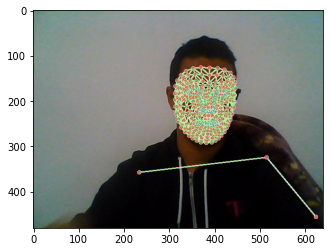

In [36]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Make Prediction in Real Time 

In [10]:
from tensorflow.keras.models import load_model

model = load_model("action_detection.h5")

In [19]:
cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture(1)
# cap.open("http://192.168.10.204:8080/video")
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #Read Feed
        ret, frame = cap.read()

        
#         print(results)
        
        if cv2.waitKey(1) & 0xFF == ord("p"):
            frame_num = 0
            Z = []
            cv2.putText(frame, "Starting Collections", (40, 50), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
            cv2.imshow("Cam Feed", frame)
            cv2.waitKey(2000)
            for frame_num in range(20):
                #Make detection
                image, results = mediapipe_detection(frame, holistic)
                keypoints = extract_keypoints(results)
                Z.append(keypoints)
            action_to_predict = np.array(Z)
            x = np.expand_dims(action_to_predict, axis=0)
            print(x.shape)
            prediction = model.predict(x)
            print(prediction)
            print(actions[np.argmax(prediction)])
        
        cv2.imshow("Cam Feed", frame)


        if cv2.waitKey(10) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()

(1, 20, 1662)
[[1.0000000e+00 8.0829384e-16 2.8809407e-15]]
hello


In [17]:
cap.release()
cv2.destroyAllWindows()